# 2020 Global Flood Validation Metrics 
## For Submission
Written in Python 2

In [93]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import glob
import datetime
import matplotlib as plt
import datetime as datetime  
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
%matplotlib inline

# Step 1: Calculate erorr metrics for each flood

### Run this section if you need to recalculate error metrics for each flood; otherwise skip to Step 2 to visualize and analyze

### Read and Examine Data Structure

In [95]:
%cd /Users/ckuhn/Documents/Coauthor/GFD_Tellman/data/
raw = pd.read_csv('gfd_validation_points_2018_12_17.csv',index_col=None, header=0)

/Users/ckuhn/Documents/Coauthor/GFD_Tellman/data


In [96]:
# dataframe first row
raw.head(1)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,B1,B2,B3,B4,B5,B7,MNDWI,...,pixel_lon,point_lat,point_lon,random,std_2day,std_3day,otsu_2day,otsu_3day,strata,validation
0,0,0,0,792.15651,896.579047,761.223987,1833.576595,980.842213,516.20095,-0.044882,...,87.277107,25.681778,87.277107,0.853473,0.0,0.0,0.0,0.0,0,0.0


In [97]:
# dataframe shape
print(raw.shape)

# dataframe column headers
raw.columns

(33141, 27)


Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'B1', 'B2', 'B3', 'B4',
       'B5', 'B7', 'MNDWI', 'NDVI', 'analyst', 'date', 'dfoID', 'id', 'lon',
       'pixel_lat', 'pixel_lon', 'point_lat', 'point_lon', 'random',
       'std_2day', 'std_3day', 'otsu_2day', 'otsu_3day', 'strata',
       'validation'],
      dtype='object')

In [98]:
# Validation** = student classification  
# Strata** = DFO classification

print('no. of unique floods:', len(raw['dfoID'].unique()))
print('no of validation points:', len(raw))

print('representative breakdown:')
print('no of dry points:', len(raw.loc[raw['std_2day'] == 0]))
print('no of permanent water points:', len(raw.loc[raw['std_2day'] == 1]))
print('no of flooded points:', len(raw.loc[raw['std_2day'] == 2]))

no. of unique floods: 123
no of validation points: 33141
representative breakdown:
no of dry points: 8078
no of permanent water points: 8107
no of flooded points: 16952


#### Drop floods with fewer than 100 points

In [11]:
df = raw.groupby('dfoID').filter(lambda g: g.dfoID.count() >= 100)
#df.dfoID.unique()

#### Drop NA values

In [12]:
# Pixels got labeled "NAN" were coded as either -99 or 99 
df = df.loc[df['validation'] > -1]
df = df.loc[df['validation'] < 99]

## Calculate error metrics

### Background

The points were stratified into three classes or strata. They are 50% not flooded (permanent water + dry) and 50% flooded. 
- not flooded/dry (0)
- permanent water (1)
- flooded (2)

Four methods were used: 
- standard approach, 2 days
- standard approach, 3 days
- otsu, 2 days
- otsu 3 days


The **Validation** column is the student classification    
The **Strata** column is the DFO classification

### Select and prepare the method to analyze

In [9]:
# Isolate each of the methods
st2 = df.filter(['dfoID', 'std_2day','strata', 'validation' ], axis=1)
st3 = df.filter(['dfoID', 'std_3day','strata', 'validation' ], axis=1)
ot2 = df.filter(['dfoID', 'otsu_2day','strata', 'validation' ], axis=1)
ot3 = df.filter(['dfoID', 'otsu_3day','strata', 'validation' ], axis=1)

In [10]:
# # Select which collection to analyze: 

# Create a label for the method to use in filenaming
method = st2
method_name = 'std_2day'

method['model_score'] = method[method_name]
method['student_score'] = method['validation']

print(method.groupby('model_score')['dfoID'].count())
# Remember: strata = 0 = dry, 1 = permanent water, 2 = flood
print(method.groupby(['student_score'])['dfoID'].count())

model_score
0.0     7424
1.0     7481
2.0    15628
Name: dfoID, dtype: int64
student_score
0.0    11497
1.0    19036
Name: dfoID, dtype: int64


## Calculate Confusion Matrix

#### matrix components


- true positive = Validation (1) + Strata(4) = 5
- true negative = Validation (0) + Strata (0) =  0 
- false positive = Validation (0) + Strata (4) = 4
- false negative = Validation (1) + Strata (0) = 1

### Calculate  metrics

In [ ]:
method['model_score'] = method['model_score'].multiply(2)
method['model_score'].value_counts()
# 0 - dry, 2 - permanent water - 4 - floods
# 0 - dry, 1 - flooded
method['student_score'].value_counts()
# Add them together
method['score']  = method['model_score'] + method['student_score'] 
method['score'].value_counts()

# True Positive = Validation (1) + Strata (4)
tp = len(method.loc[method['score']== 5])
# True Negative = Validation (0) + Strata (0)
tn = len(method.loc[method['score']== 0])
# False Positive = Validation (0) + Strata (4)
fp = len(method.loc[method['score']== 4])
# False Negative = Validation (1) + Strata (0)
fn = len(method.loc[method['score']== 1])


precision = tp / (tp + fp)
recall  = tp / (tp + fn)  # % of flooded pixels it ID'ed correctly
accuracy = (tn + tp) / (tn+tp+fp+fn)
commission = fp / (tp + fp)  # modeled positives over all true positives
omission = fn / (tp + fn)

total = tn+tp+fn+fp
print('True Negatives(%)',tn/total) #32   Sep 2018 updates: 30%
print('True Positives(%)',tp/total) #52   Sep 2018 updates: 52%
print('False Positives(%)',fp/total) #15  Sep 2018 updates: 16%
print('False Negatives(%)',fn/total) # <0.01  Sep 2018 updates: 1.6%
print(total)
print(accuracy)
print(commission)
print(omission)

In [ ]:
col_names =  ['Method', 'tp', 'tn','fp','fn',
             'precision','recall','overall_accuracy',
             'commission','omission'] ### Column names for making data frames for each flood

my_df  = pd.DataFrame(columns = col_names)## Make empty data frame to put values for each sampling level in

### Create new dataframe for that method

In [ ]:
std_2day = [method_name, tp, tn, fp, fn, precision, recall, accuracy, commission, omission]
#std_3day = [method_name, tp, tn, fp, fn, precision, recall, accuracy, commission, omission]
#otsu_2day = [method_name, tp, tn, fp, fn, precision, recall, accuracy, commission, omission]
#otsu_3day = [method_name, tp, tn, fp, fn, precision, recall, accuracy, commission, omission]

In [ ]:
std2_short  = pd.DataFrame([std_2day], columns = col_names)## Make empty data frame to put values for each sampling level in
# std3_short  = pd.DataFrame([std_3day], columns = col_names)## Make empty data frame to put values for each sampling level in
# ot2_short  = pd.DataFrame([otsu_2day], columns = col_names)## Make empty data frame to put values for each sampling level in
# ot3_short  = pd.DataFrame([otsu_3day], columns = col_names)## Make empty data frame to put values for each sampling level in

In [ ]:
## Optional step: add dataframes together
# all_data = std2_short.append(std3_short).append(ot3_short).append(ot2_short)
# all_data

# Step 2: Plot  error metrics

In [99]:
%cd '/Users/ckuhn/Documents/Coauthor/GFD_Tellman/data/'
my_df = pd.read_csv('gfd_validation_metrics.csv').drop(['Unnamed: 0', 'MNDWI', 'NDVI'], axis=1)
my_df.head(2)

/Users/ckuhn/Documents/Coauthor/GFD_Tellman/data


,Flood,Method,Latitude,Longitude,tp,tn,fp,fn,fp_jrc,tp_jrc,precision,recall,overall_accuracy,commission,omission,counts
0,4098,std_3day,24.662609,87.105573,116.0,58.0,9.0,2.0,5.0,55.0,0.928,0.983051,0.940541,0.072,0.016949,245.0
1,4098,otsu_3day,24.662609,87.105573,116.0,58.0,9.0,2.0,5.0,55.0,0.928,0.983051,0.940541,0.072,0.016949,245.0


In [100]:
dfmelted = pd.melt(my_df, id_vars = ['Flood', 'Method', 'counts'], var_name = 'metric', value_name = 'value')

In [101]:
error = dfmelted.loc[dfmelted['metric'].isin(['commission','omission'])]
overall = dfmelted.loc[dfmelted['metric'].isin(['overall_accuracy','precision','recall' ])]
basics = dfmelted.loc[dfmelted['metric'].isin(['tp','tn','fp', 'fn' ])]

In [102]:
overall.groupby(['Method', 'metric'])['value'].agg(['mean', 'std'])

mean       std
Method    metric                              
otsu_2day overall_accuracy  0.818962  0.135054
          precision         0.773237  0.212571
          recall            0.918766  0.121110
otsu_3day overall_accuracy  0.804849  0.123519
          precision         0.788816  0.207127
          recall            0.845200  0.170417
std_2day  overall_accuracy  0.823720  0.152845
          precision         0.770245  0.215143
          recall            0.965914  0.055223
std_3day  overall_accuracy  0.826149  0.145905
          precision         0.772862  0.214098
          recall            0.961809  0.059423

In [103]:
basics = basics.replace(['std_3day', 'otsu_2day', 'std_2day', 'otsu_3day'],['3Day Standard', '2Day Otsu', '2Day Standard', '3Day Otsu'])
basics = basics.replace(['tp', 'tn', 'fp', 'fn'],['True Positive', 'True Negative', 'False Positive', 'False Negative'])

/Users/ckuhn/Documents/Coauthor/GFD_Tellman/figures


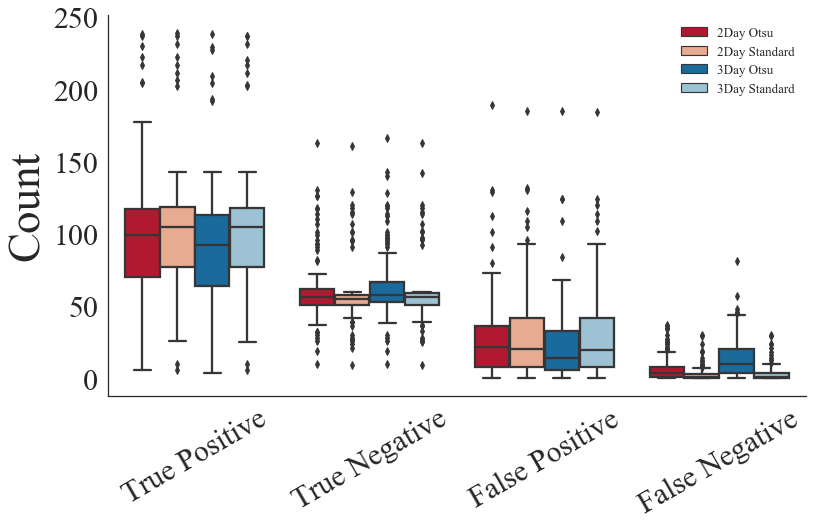

In [104]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
set_style()  

order = 'True Positive', 'True Negative', 'False Positive', 'False Negative'

g = sns.factorplot(kind='box',        # Boxplot
               y='value',       # Y-axis - values for boxplot
               x='metric',        # X-axis - first factor
               hue = 'Method',
               hue_order  = ['2Day Otsu', '2Day Standard', '3Day Otsu', '3Day Standard'],
               data=basics,        # Dataframe 
               order = order,
               size=8,            # Figure size (x100px)      
               aspect=1.5, 
               palette= ['#ca0020', '#f4a582', '#0571b0', '#92c5de'],  # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot
#g.fig.get_axes()[0].set_yscale('log')

#g.fig.text(0.75, 0.75,'n = 121 floods', fontsize=30, color = '#ff3d00') #add text

g.set_xticklabels(rotation=30)

plt.ylabel('Count', fontsize = 45)
plt.xlabel('', fontsize = 45)
plt.title('', fontsize = 45)
#plt.axhline(y=0, color='grey', ls='--')
#plt.legend(loc='upper left', fontsize=45)
plt.legend()
plt.tight_layout()

%cd /Users/ckuhn/Documents/Coauthor/GFD_Tellman/figures/
plt.savefig('GFD_basics.png', dpi = 300)

# plt.show()

#http://queirozf.com/entries/matplotlib-pyplot-by-example#change-tick-label-rotation # ADD LABELS

In [105]:
basics.groupby(['Method', 'metric'])['value'].mean()

Method         metric        
2Day Otsu      False Negative      6.974359
               False Positive     27.709402
               True Negative      61.239316
               True Positive      98.085470
2Day Standard  False Negative      3.228814
               False Positive     30.381356
               True Negative      58.305085
               True Positive     101.296610
3Day Otsu      False Negative     14.025641
               False Positive     23.418803
               True Negative      65.529915
               True Positive      91.034188
3Day Standard  False Negative      3.661017
               False Positive     29.542373
               True Negative      59.144068
               True Positive     100.864407
Name: value, dtype: float64

In [106]:
error.groupby(['Method', 'metric'])['value'].agg(['mean', 'std'])

mean       std
Method    metric                        
otsu_2day commission  0.226763  0.212571
          omission    0.081234  0.121110
otsu_3day commission  0.211184  0.207127
          omission    0.154800  0.170417
std_2day  commission  0.229755  0.215143
          omission    0.034086  0.055223
std_3day  commission  0.227138  0.214098
          omission    0.038191  0.059423

In [107]:
overall.groupby(['Method', 'metric'])['value'].agg(['mean', 'std'])

mean       std
Method    metric                              
otsu_2day overall_accuracy  0.818962  0.135054
          precision         0.773237  0.212571
          recall            0.918766  0.121110
otsu_3day overall_accuracy  0.804849  0.123519
          precision         0.788816  0.207127
          recall            0.845200  0.170417
std_2day  overall_accuracy  0.823720  0.152845
          precision         0.770245  0.215143
          recall            0.965914  0.055223
std_3day  overall_accuracy  0.826149  0.145905
          precision         0.772862  0.214098
          recall            0.961809  0.059423

# Step 3: Test Number of Points

This step takes a subsample of floods we used for testing and determines how the accuracy changes as a function of the number of points tha tyou sample

In [75]:
%cd '/Users/ckuhn/Documents/Coauthor/GFD_Tellman/'
df = pd.read_csv('gfd_validation_sensitivity.csv')

/Users/ckuhn/Documents/Coauthor/GFD_Tellman


In [76]:
raw = df.copy()
raw.head(1)

,Unnamed: 0,B1,B2,B3,B4,B5,B7,MNDWI,NDVI,analyst,date,dfoID,id,lat,lon,random,strata,validation,score
0,0,675.522719,1128.643606,2015.265677,2436.991734,3702.040962,2753.348602,-0.365915,0.095263,HT,5/10/18,2143,0,-21.762688,123.87866,0.341315,0,0,0


In [77]:
# These are the ones we are going to drop 
raw3 = raw.groupby('dfoID').filter(lambda g: g.dfoID.count() < 200)
raw3.dfoID.unique()

#From the first round of classifications
raw = raw[raw.dfoID != 4507]
raw = raw[raw.dfoID != 2586]

In [78]:
floods = list(set(raw.dfoID)) ## Get a list of all the unique values of floods
sampling_levels = np.arange(0, 400, 1)

#sampling_levels = [10,20,30,40,50,60,100] ### Set levels you want to sample at 

col_names =  ['Flood','NumofPoints', 'tp', 'tn','fp','fn',
             'precision','recall','overall_accuracy',
             'commission','omission'] ### Column names for making data frames for each flood

my_df  = pd.DataFrame(columns = col_names)## Make empty data frame to put values for each sampling level in

for i in floods:  ### Loop through floods
    df_full = raw.loc[raw['dfoID']== i] ### subset data frame by single flood
    for j in sampling_levels: ## Loop through sampling levels
        df = df_full.sample(j) ##Apparently pandas has a built-in dataframe random sampler!
        tp = float(len(df.loc[df['score']== 5])) 
        tn = float(len(df.loc[df['score']== 0]))
        fp = float(len(df.loc[df['score']== 4]))
        fn = float(len(df.loc[df['score']== 1]))
        ### Calculating values!
        if tp == 0: ###Hmm, sometimes there are no tp scores, so you get a zero divide error
            continue ###I've put this in for now but it's gonna bite your butt eventually
        precision = tp / (tp + fp)
        recall  = tp / (tp + fn)  # % of flooded pixels it ID'ed correctly
        accuracy = (tn + tp) / (tn+tp+fp+fn)
        commission = fp / (tp + fp)  # modeled positives over all true positives
        omission = fn / (tp + fn)
        ##add a new row to the dataframe based on this sampling level!
        my_df.loc[len(my_df)] = [i,j, tp, tn, fp, fn, precision, recall, accuracy, commission, omission]

        ###Now you should have a full dataframe with all your sampling levels for each flood
        ###SO
#my_df.to_csv('myprecious.csv', encoding='utf-8')

In [79]:
my_df.head(1)

,Flood,NumofPoints,tp,tn,fp,fn,precision,recall,overall_accuracy,commission,omission
0,4163.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [80]:
print(my_df.commission.mean())
print(my_df.omission.mean())
print(my_df.overall_accuracy.mean())

0.17346292877842398
0.025846575186897005
0.8749003938035954


In [82]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
    plt.rc({'axes.titlesize': 'large'})
set_style()  

(0, 400)

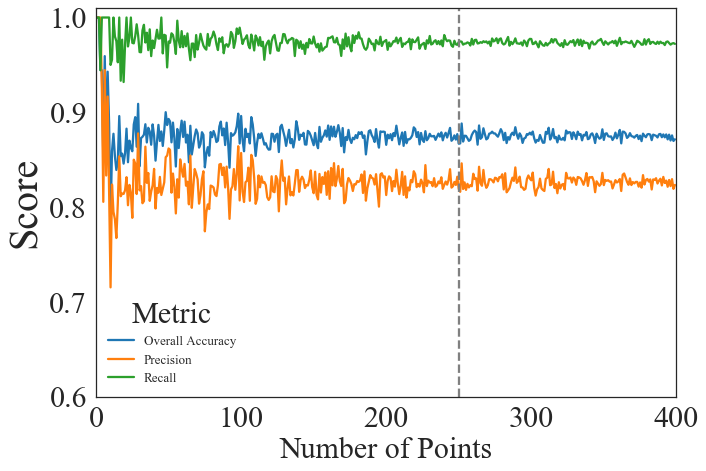

In [91]:
my_df.groupby(['NumofPoints'])['overall_accuracy'].mean().plot(label='Overall Accuracy')

plt.xlabel('Number of Points', fontsize=30)

my_df.groupby(['NumofPoints'])['precision'].mean().plot(label='Precision')
plt.xlabel('Number of Points', fontsize=30)

my_df.groupby(['NumofPoints'])['recall'].mean().plot(label='Recall')
plt.xlabel('Number of Points', fontsize=30)
plt.ylabel ('Score', fontsize=40)
plt.legend(title="Metric")

plt.axvline(250, color='grey', linestyle='--')

plt.ylim(0.6,1.01)
plt.xlim(0,400)

# %cd /Users/ckuhn/Documents/Coauthor/DFO_Accuracy/figures/
# plt.savefig('point_test_accuracy_n10_2019_revisions.png', dpi = 300)

### Std. Dev of Accuracy @ any given number of points

In [85]:
df = my_df.groupby(['NumofPoints'])['overall_accuracy'].agg(['mean','var', 'std']).reset_index()

df.loc[df['NumofPoints']==250]['std'].mean()

0.09778886675976595